# Lecture 8 Discrete Optimization

In [69]:
import numpy as np
import pandas as pd
from collections import defaultdict
import urllib.request
import pulp

import matplotlib.pyplot as plt
%config InlineBackend.figure_formats = ['svg']

## Pre-Reading
- [Linear Programming Intro](https://byjus.com/maths/linear-programming/#:~:text=Linear%20programming%20is%20the%20method,be%20obtained%20in%20those%20conditions.) (can skip "Simplex Method" section)

## Learning Objectives

- Contrast discrete vs. continuous optimization.
- Contrast an objective function vs. constraints.
- Convert between English descriptions of objective/constraint functions and PuLP code.
- Solve an integer linear program using the PuLP library.

## Discrete Optimization Intro/Example

- **Optimization** refers to maximizing or minimizing a function with respect to its inputs.
  - **Example 1a:** find the minimum of $f(x)=(x-0.9)^2$. The answer is $0$, when $x=0.9$.
- **Discrete optimization** refers to optimization where the variables are _discrete_ (as opposed to continuous).
  - **Example 1b:** find the minimum of $f(x)=(x-0.9)^2$ where $x$ is an integer. The answer is $0.01$, when $x=1$.




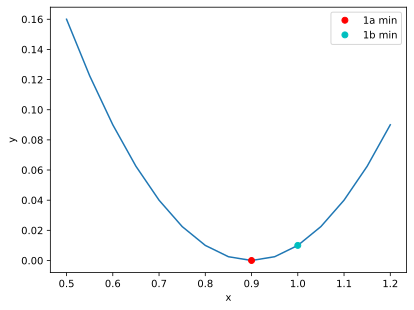

In [70]:
x = np.arange(0.5, 1.25, 0.05)

plt.plot(x, (x-0.9)**2)
plt.plot(0.9, 0, 'ro', label="1a min")
plt.plot(1, 0.01, 'co', label="1b min")
plt.legend()
plt.xlabel('x')
plt.ylabel('y');

#### Example Problem

**Example 2:** find the length-8 string of letters (e.g. `aaaaaaaa`, `abcdefgh`, etc.) that contains the most English words in it.

- Because the problem is discrete, we can count the number of "options" or "configurations".
  - In **Example 1** above, $x$ is any integer so there are infinitely many.
  - In **Example 2**, if we're just using the 26 lower-case letters, we have $26^8$ possibilities.

In [71]:
26**8

208827064576

That is a lot!


If the number of possibilities is finite, you can enumerate (or list) all possible configurations (inputs).
  - In our example, there is `aaaaaaaa`, `aaaaaaab`, `aaaaaaac`, ..., `zzzzzzzz`. 
  - This is called "brute force search".
  - Often, it's not computationally feasible to search through all possible combinations because there are too many. 
  - So we need smarter algorithms that can somehow learn to ignore or "throw away" large numbers of possibilities without explicitly checking them.

#### Specifying an Optimization Problem

To specify the problem, we need to specify a few things:

1. A description of the **space of possible inputs**.
2. An **objective function** which takes an input and computes a score. 
3. Are we **maximizing or minimizing**?

In **Example 2**, the space of possible inputs is all length-8 strings. And the objective function is the number of English words in the string, and we are maximizing it. 

#### Solving an Optimization Problem with Brute Force (example)

First, let's implement the objective function in Python

In [73]:
words_file = urllib.request.urlopen("https://gist.githubusercontent.com/deekayen/4148741/raw/01c6252ccc5b5fb307c1bb899c95989a8a284616/1-1000.txt")
word_list = {s.decode("utf-8").strip().lower() for s in words_file.readlines()}

- Note on the above: we're just using the 1000 most common English words. 
- I tried a full corpus of English words but it turns out a lot of strange things are English words, like "t" or "ea".

In [74]:
def english_words_in_string(s):
    """
    Find all the English words within a string.
    
    Parameters
    ----------
    s : str
        The input string.
       
    Returns
    -------
    set
        The set of English words contained in s.
        
    Example
    -------
    >>> english_words_in_string("theapple")
    {'a', 'apple', 'he', 'the'}
    """
    
    words = set()
    for start in range(len(s)):
        for end in range(start+1, len(s)+1):
            if s[start:end] in word_list:
                words.add(s[start:end])
    return words

In [75]:
english_words_in_string("theapple")

{'a', 'apple', 'he', 'the'}

It looks like the length-8 string `theapple` contains a bunch of words.

Next, let's implement the objective function:

In [76]:
def objective_fun(s):
    """Count the number of English words contained within a string."""
    return len(english_words_in_string(s))

objective_fun("theapple")

4

The score given by the objective function for `theapple` is 4. We are trying to find the string (or strings - the solution is not always unique) that make this value as large as possible.

**Note:** For the next parts, we'll restrict ourselves to only using the first 5 letters of the alphabet (a, b, c, d, e) so that the code isn't too slow. This way we should only have:

In [77]:
5**8

390625

possibilities, which is reasonable. We'll grab this function from Lab 3's question on tricky recursive code:

In [78]:
def get_inputs(letters, n):
    """
    Return all length-n strings using letters.
    
    Parameters
    ----------
    letters : list
        The list of letters (could be a string or a list)
    
    n : int
        The desired length.
        
    Returns
    -------
    list
        A list of the resulting strings.
        
    Examples
    --------
    get_inputs(['a', 'b', 'c'], 2)
    ['aa', 'ab', 'ac', 'ba', 'bb', 'bc', 'ca', 'cb', 'cc']
    """
    
    if n == 0:
        return [""]

    return [letter + l for letter in letters for l in get_inputs(letters, n-1)]

In [79]:
inputs = get_inputs(['a', 'b', 'c', 'd', 'e'], 8)

In [80]:
inputs[:10] # print out the first 10

['aaaaaaaa',
 'aaaaaaab',
 'aaaaaaac',
 'aaaaaaad',
 'aaaaaaae',
 'aaaaaaba',
 'aaaaaabb',
 'aaaaaabc',
 'aaaaaabd',
 'aaaaaabe']

In [81]:
scores = list(map(objective_fun, inputs))
np.max(scores)

5

5 words using only 5 letters! Let's see what string led to this:

In [82]:
best_s = inputs[np.argmax(scores)]
best_s

'aabedadd'

And the words:

In [83]:
english_words_in_string(best_s)

{'a', 'add', 'be', 'bed', 'dad'}

Can you imagine coming up with this by hand?

We can also check if the solution is unique:

In [84]:
np.sort(scores)

array([0, 0, 0, ..., 5, 5, 5])

Looks like the solution is not unique (we see several 5's). 

- How long would the same optimization problem take if we were to consider all 26 alphabet letters and a 10-letter string?

In [85]:
time_per_one_call = %timeit -o -r 5 -n 1000 objective_fun(inputs[0])

7.41 μs ± 2.71 μs per loop (mean ± std. dev. of 5 runs, 1,000 loops each)


In [86]:
26**10 * time_per_one_call.average / (3600 * 24 * 30 * 12)

33.63698083547089

About 30 years! Even for this simple problem. It doesn't take long before we need something better than brute force...

#### Another Example: Shortest Path in a Graph

- Last week, we talked about finding the shortest path between two nodes $A$ and $B$ in a graph.
- This is itself a discrete optimization problem.

1. Possible inputs: all possible paths from $A$ to $B$.
2. Objective function: the length of the path.
3. We are minimizing.

#### Solving an Optimization Problem

- There are many ways to go about solving an optimization problem.
- In general, one possibility is _brute force_ in which all possible inputs are considered.
- That's the approach we just took in our toy example above.
- But this is often infeasible because it would be too slow.
  - Think about $26^8$ strings.
  - Think about all possible paths between two nodes in the Facebook graph!
- So, the hard part about optimization is often in finding clever ways to solve the problem faster, that still give the correct solution.
  - E.g. breadth-first search to find the shortest distance in a graph.
  - For the English words problem, there is nothing better than brute force. But there often is.
- The other hard part can be **converting a conceptual idea into the right mathematical form as** an optimization problem. This is called _formulating_ the problem.

## Constraints

- A popular way of expressing the space of possible inputs is to put _constraints_ on the possibilities.
- Example: all length-8 strings such that each letter appears at most twice.
  - `aabbccdd` is valid, `abcdefgh` is valid, but `aaabbbcc` is _not_ valid ("violates the constraint").
- You could say that this is just a change in the possible inputs, and it is.
  - But, because of how these problems are solved under the hood, we often think of constraints as a separate thing.
  

To specify an optimization problem, we need to specify a few things:

1. A specification of the space of possible inputs.

2. An _objective function_ which takes an input and computes a score. 
4. (Optional) A set of _constraints_, which take an input and return true/false.
3. Are we maximizing or minimizing?

In [87]:
def characters_appear_at_most_twice(s, n=2):
    """
    Checks whether all characters appear at most n times in s.
    If any character appears n+1 or more times, returns False.
    
    Parameters
    ----------
    s : str
        The input string
    n : int, optional
        The maximum number of times a character is allowed to appear (default: 2)
        
    Returns
    -------
    bool
        Whether or not all characters appear at most twice
        
    Examples
    --------
    >>> characters_appear_at_most_twice("aabbccdef")
    True
    >>> characters_appear_at_most_twice("aaa")
    False
    >>> characters_appear_at_most_twice("aaa", 5)
    True
    """
    
    return max(s.count(char) for char in s) <= n

In [88]:
assert characters_appear_at_most_twice("aabbccdef")
assert not characters_appear_at_most_twice("aaa")
assert characters_appear_at_most_twice("aaa", 5)

Now we can solve the _constrained optimization problem_:

In [89]:
inputs[:10] # the ones from before

['aaaaaaaa',
 'aaaaaaab',
 'aaaaaaac',
 'aaaaaaad',
 'aaaaaaae',
 'aaaaaaba',
 'aaaaaabb',
 'aaaaaabc',
 'aaaaaabd',
 'aaaaaabe']

In [90]:
constrained_inputs = [s for s in inputs if characters_appear_at_most_twice(s)]

In [91]:
len(inputs)

390625

In [92]:
len(constrained_inputs)

63000

In [93]:
constrained_inputs[:10]

['aabbccdd',
 'aabbccde',
 'aabbcced',
 'aabbccee',
 'aabbcdcd',
 'aabbcdce',
 'aabbcddc',
 'aabbcdde',
 'aabbcdec',
 'aabbcded']

In [94]:
# Find the maximum score from our set of constrained inputs
constrained_scores = list(map(objective_fun, constrained_inputs))
np.max(constrained_scores)

4

In [95]:
# Find the input with that max score
constrained_best_s = constrained_inputs[np.argmax(constrained_scores)]
constrained_best_s

'abadbedc'

In [96]:
english_words_in_string(constrained_best_s)

{'a', 'bad', 'be', 'bed'}

Some things to note:

- The constrained optimum can be **equal to or worse than** the unconstrained optimum.
  - In this case it was worse - we got 4 words instead of 5 by not allowing repeats.
  
- The solution to the constrained problem might be completely different from the unconstrained.
  - For example, here we don't have just 4 of the original 5 words - we have a new word, "bad'.
- It is possible to have multiple constraints.
  - In this case we only had one constraint.
  - In general, for an input to be valid, _all_ the constraints must be satisfied. 
  - For example: each letter appears at most twice AND the string is a palindrome AND it does not contain the substring "ab" (3 constraints).

## TA Assignment Example: Introduction

Consider the problem of assigning TAs to labs in MDS.

In [97]:
TAs_df = pd.read_csv("data/TA_apps.csv").set_index("name")
str_to_list = lambda s: list(map(int,s.split(",")))
TAs_df["can_teach"   ] = TAs_df["can_teach"  ].apply(str_to_list)
TAs_df["enthusiastic"] = TAs_df["enthusiastic"].apply(str_to_list)
TAs_df

,availability,R_proficiency,python_proficiency,can_teach,enthusiastic
name,,,,,
Amin,MT,competent,expert,"[573, 551, 552, 522]","[511, 571, 513]"
Chris,MTR,expert,expert,"[511, 521, 512, 552, 532]","[521, 512, 552]"
Colby,MW,expert,beginner,"[511, 551, 531, 561]","[521, 573, 523, 522]"
Justin,MTWR,competent,expert,"[511, 521, 523, 531, 512]","[521, 512, 513]"
Katie,TW,competent,none,"[551, 523, 531, 552, 561]","[551, 523, 561, 522]"
Melika,TWR,expert,competent,[531],"[511, 551, 523, 552, 561, 522]"
Mobina,R,expert,expert,"[512, 532, 513]","[512, 513]"
Rafi,MTW,expert,none,"[573, 551, 532, 571]","[511, 521]"
Siddhesh,MW,expert,expert,"[573, 551, 523, 552, 571]","[551, 552, 571]"


In [98]:
TAs = TAs_df.index.values.tolist()
TAs

['Amin',
 'Chris',
 'Colby',
 'Justin',
 'Katie',
 'Melika',
 'Mobina',
 'Rafi',
 'Siddhesh',
 'Yi Xuan']

In [99]:
courses_df = pd.read_csv("data/MDS_courses.csv").set_index("course_number")
courses_df

,course_title,slug,block,primary_lang,lab_days
course_number,,,,,
511,Programming for Data Science,py-prog,1,python,WR
521,Computing Platforms for Data Science,platforms-dsci,1,none,MT
551,Descriptive Statistics and Probability for Dat...,stat-prob-dsci,1,R,MT
523,Programming for Data Manipulation,r-prog,1,R,WR
512,Algorithms and Data Structures,alg-data-struct,2,python,TR
531,Data Visualization I,viz-1,2,both,MW
552,Statistical Inference and Computation I,stat-inf-1,2,R,MT
571,Supervised Learning I,sup-learn-1,2,python,WR
513,Databases and Data Retrieval,database-data-retr,3,none,WR


In [100]:
courses = courses_df.index.values.tolist()
courses

[511, 521, 551, 523, 512, 531, 552, 571, 513, 522, 561, 573]

In [101]:
blocks = set(courses_df["block"])
blocks

{1, 2, 3}

Goal: match TAs to courses so that our staffing needs are covered in the best way possible.

Ok, let's make this more concrete. Here are the **constraints**:

- Each course should be assigned exactly 2 TAs.
- A TA can only cover one course at a time (i.e., in a given block).
- A TA can only be assigned to a course they have listed as "can teach" or "enthusiastic to teach".
- To cover a course, the TA must be available for one of the two lab days (for simplicity - this does not quite guarantee lab coverage).

And here is the **objective**:

- We want to maximize the number of assigned courses that TAs are enthusiastic about.

## Formulating an Optimization Problem

#### Are we maximizing or minimizing?

We are maximizing. We want as much enthusiasm as possible!

In [102]:
prob = pulp.LpProblem("TA-assignments", pulp.LpMaximize)

#### Setting up the decision variables

- For this problem, what are our _decision variables_? 
- Turns out such problems are best handled with _binary variables_.

Let $x_{ij}$ be $1$ if TA $i$ is assigned to course $j$, and 0 otherwise.

In [103]:
x_df = pd.DataFrame(data=(np.random.rand(len(TAs),len(courses))<.2).astype(int), index=TAs, columns=courses)
x_df

,511,521,551,523,512,531,552,571,513,522,561,573
Amin,0,0,0,0,0,0,0,0,0,0,0,0
Chris,0,0,0,0,1,0,0,1,0,1,0,0
Colby,0,0,0,0,0,0,1,0,0,1,1,0
Justin,1,0,0,0,0,0,0,0,0,0,0,1
Katie,0,0,0,0,0,1,0,1,0,0,0,0
Melika,0,0,1,0,0,0,0,0,0,0,0,0
Mobina,0,0,0,0,0,0,0,0,1,1,1,0
Rafi,0,1,0,1,1,0,0,0,0,0,1,0
Siddhesh,0,0,0,0,1,0,0,1,1,0,0,0
Yi Xuan,1,0,0,0,1,0,0,1,0,1,0,1


**NOTE**: this table is not used for solving the problem below - it is only for illustration!

In [104]:
# This is constructing a matrix of variables as shown in the example above
# It is structured as a Python dictionary (hence the use of .dicts)
# As in the matrix above, there is one variable for each TA/course pair
# Each variable is an integer between 0-1.
x = pulp.LpVariable.dicts("x", (TAs, courses), 0, 1, pulp.LpInteger)

Let's check out the type of one of these variables:

In [105]:
type(x["Chris"][512])

pulp.pulp.LpVariable

How many possible tables are there? (ignoring constraints)

In [106]:
num_entries = len(TAs) * len(courses)
num_entries

120

In [107]:
2**num_entries

1329227995784915872903807060280344576

##### `<optional>`

Is our formulation "efficient" ?

- With $2$ TAs per course (2 spots) and $10$ possible TAs, we will have $_{10}C_2 = \frac{10!}{2! \: 8!} = 45$ possibilities for each course.

- With $12$ courses, we'll have $45^{12}$ possibilities in total:

In [108]:
45**len(courses)

68952523554931640625

- Our formulation with binary variables has _more_ configurations because it doesn't have the "2 TAs per course" constraint hardwired into it. 
- This seems "redundant" but is actually the way to go because it allows us to use PuLP. 
- Even though we generate a situation with so many more possibilities, this is still the best approach.


#### Setting up the constraints

We now have to change our English constraints into constraints on $x$:

**Constraint 1:** _Each course should be assigned exactly 2 TAs._
  - For all courses $j$, we require $\sum_i x_{ij} = 2$
  - That is, the sum of TAs for DSCI 511 equals 2, the sum of TAs for DSCI 521 equals 2, ...


In [109]:
TAS_PER_COURSE = 2

In [110]:
# For each course, we should have exactly 2 assigned TAs
for course in courses:
    # pulp.lpSum is the same as `sum` or using + several times
    # It is just more efficient because it tells pulp we are doing several additions altogether.
    prob += ( pulp.lpSum(x[TA][course] for TA in TAs) == TAS_PER_COURSE )

In [111]:
print(prob)

TA-assignments:
MAXIMIZE
None
SUBJECT TO
_C1: x_Amin_511 + x_Chris_511 + x_Colby_511 + x_Justin_511 + x_Katie_511
 + x_Melika_511 + x_Mobina_511 + x_Rafi_511 + x_Siddhesh_511 + x_Yi_Xuan_511
 = 2

_C2: x_Amin_521 + x_Chris_521 + x_Colby_521 + x_Justin_521 + x_Katie_521
 + x_Melika_521 + x_Mobina_521 + x_Rafi_521 + x_Siddhesh_521 + x_Yi_Xuan_521
 = 2

_C3: x_Amin_551 + x_Chris_551 + x_Colby_551 + x_Justin_551 + x_Katie_551
 + x_Melika_551 + x_Mobina_551 + x_Rafi_551 + x_Siddhesh_551 + x_Yi_Xuan_551
 = 2

_C4: x_Amin_523 + x_Chris_523 + x_Colby_523 + x_Justin_523 + x_Katie_523
 + x_Melika_523 + x_Mobina_523 + x_Rafi_523 + x_Siddhesh_523 + x_Yi_Xuan_523
 = 2

_C5: x_Amin_512 + x_Chris_512 + x_Colby_512 + x_Justin_512 + x_Katie_512
 + x_Melika_512 + x_Mobina_512 + x_Rafi_512 + x_Siddhesh_512 + x_Yi_Xuan_512
 = 2

_C6: x_Amin_531 + x_Chris_531 + x_Colby_531 + x_Justin_531 + x_Katie_531
 + x_Melika_531 + x_Mobina_531 + x_Rafi_531 + x_Siddhesh_531 + x_Yi_Xuan_531
 = 2

_C7: x_Amin_552 + x_Chr

- Above: in PuLP we use the `+=` syntax to add a new constraint to the optimization problem.
  - No code to solve the optimization problem is actually been run here.
  - Rather, PuLP is using the syntax of python to allow the user to specify the problem over multiple lines of code.
  - You will see this "language within a language" pattern again in DSCI 572 and DSCI 553, and maybe other places.
- Also, you can think of `pulp.lpSum` as the same as `sum` or `np.sum`.
  - However, it's not doing the summing now, like we usually do with python code.
  - It's just a way of communicating the math of the optimization problem. 

<br>

**Constraint 2:** _A TA can only cover one course at a time (i.e., in a given block)._
  - For all TAs $i$, for all blocks $B$, we require $\sum_{j\in B} x_{ij} \leq 1$
  - That is, the sum of Alice's Block 1 courses is at most 1, the sum of Bob's Block 1 courses is at most 1, ...

In [112]:
for TA in TAs:
    for block in blocks:
        courses_in_block = courses_df.query("block == @block").index
        prob += pulp.lpSum(x[TA][course] for course in courses_in_block) <= 1

<br> 

**Constraint 3:** _A TA can only be assigned to a course they have listed as "can teach" or "enthusiastic to teach"._
  - For all $i,j$ such that $\text{canteach}(i,j)$ is false and $\text{enthusiastic}(i,j)$ is false, $x_{ij}=0$
  - That is, Katie cannot teach 511 because $\text{canteach}(\text{Katie},511)$ is false and $\text{enthusiastic}(\text{Katie},511)$ is false, ...

In [113]:
for TA in TAs:
    for course in courses:
        if course in TAs_df.loc[TA,"can_teach"]:
            continue
        if course in TAs_df.loc[TA,"enthusiastic"]:
            continue
        # If we reach this point, the TA cannot teach the course
        prob += ( x[TA][course] == 0 )

<br> 

**Constraint 4:** _To cover a course, the TA must be available for one of the two lab days._
  
  - For all $i,j$ such that $\text{available}(i,\text{day1}(j))$ is false and $\text{available}(i,\text{day2}(j))$ is false, $x_{ij}=0$
  
  - That is, Amin cannot teach DSCI 513 because $\text{available}(\text{Amin,W})$ is false and $\text{available}(\text{Amin,Th})$ is false
    - And $\text{day1}(513)$ is W, $\text{day2}(513)$ is Th.

In [114]:
for TA in TAs:
    for course in courses:
        if courses_df.loc[course,"lab_days"][0] in TAs_df.loc[TA]["availability"]:
            continue
        if courses_df.loc[course,"lab_days"][1] in TAs_df.loc[TA]["availability"]:
            continue
        # If we reach this point, the TA is not available for either lab day
        prob += x[TA][course] == 0

#### Setting up the objective

- _We want to maximize the number of assigned courses that TAs are enthusiastic about._
- Below we show 2 equivalent ways of specifying this objective in PuLP.

##### 1st approach:
We want to maximize $\sum_{ij} x_{ij}$ for all $i,j$ where $\text{enthusiastic}(i,j)$ is true


In [115]:
objective_terms = list()
for TA in TAs:
    for course in courses:
        if course in TAs_df.loc[TA,"enthusiastic"]:
            objective_terms.append(x[TA][course])
prob += pulp.lpSum(objective_terms)

- Above: to specify the objective in PuLP, we again use `+=` but this time **without any boolean operator on the right side**.

##### 2nd approach:

- We can also think of the math a bit differently: maximize $\sum_{ij} \text{enthusiastic}(i,j)x_{ij}$

```python
objective_terms = list()
for TA in TAs:
    for course in courses:
        enthusiastic = course in TAs_df.loc[TA,"enthusiastic"] # True/1 if enthusiastic, False/0 otherwise
        objective_terms.append(enthusiastic * x[TA][course])
prob += pulp.lpSum(objective_terms)
```

- Above: you may need to think about this for a few minutes.
- Because $x_{ij}$ are binary and `enthusiastic` is also binary, the product is 1 only when both are 1.
  - So we're counting up the number of cases where the TA is enthusastic _and_ the TA is assigned to that course.


- Approach 1 works because the enthusiasm function is binary (yes/1 or no/0).
- But this can generalize to any sort of numbers. You could have, for example, TAs rate their enthusiasm from 1 to 10.
  - In that case, only approach 2 would work; you'd multiply the enthusiasm score by $x_{ij}$.
  - In the lab you'll need something like approach 2 for the same reason.

#### Solving the problem

In [116]:
# prob.solve()
prob.solve(pulp.apis.PULP_CBC_CMD(msg=0)) # to suppress output

1

In [117]:
pulp.LpStatus[prob.status]

'Optimal'

In [118]:
print("We have %d enthusiastic courses out of a possible %d." % 
      (pulp.value(prob.objective), len(courses)*TAS_PER_COURSE))

We have 18 enthusiastic courses out of a possible 24.


#### Printing the results

In [119]:
# Pass in "" as `data` so cells we don't fill are empty
out_df_by_TA = pd.DataFrame("", index=TAs, columns=list(blocks))
for TA in TAs:
    for course in courses:
        if pulp.value(x[TA][course]) == 1:
            out_df_by_TA.loc[TA, courses_df.loc[course, "block"]] = course
out_df_by_TA

,1,2,3
Amin,,,573
Chris,521,552,
Colby,523,531,522
Justin,521,512,513
Katie,523,531,561
Melika,551,552,561
Mobina,,512,513
Rafi,511,571,
Siddhesh,551,571,573
Yi Xuan,511,,522


In [120]:
tas_by_course = {course : list() for course in courses}
for course in courses:
    for TA in TAs:

        if pulp.value(x[TA][course]) == 1:
            tas_by_course[course].append(TA)
out_df_by_course = pd.DataFrame.from_dict(data=tas_by_course, columns=["TA 1", "TA 2"], orient="index")
out_df_by_course

,TA 1,TA 2
511,Rafi,Yi Xuan
521,Chris,Justin
551,Melika,Siddhesh
523,Colby,Katie
512,Justin,Mobina
531,Colby,Katie
552,Chris,Melika
571,Rafi,Siddhesh
513,Justin,Mobina
522,Colby,Yi Xuan


In [121]:
# Enthusiastic courses
for course in courses:
    for TA in TAs:
        if pulp.value(x[TA][course]) == 1 and course in TAs_df.loc[TA]["enthusiastic"]:
            print("%-8s is enthusiastic about DSCI %d!" % (TA, course))

Rafi     is enthusiastic about DSCI 511!
Yi Xuan  is enthusiastic about DSCI 511!
Chris    is enthusiastic about DSCI 521!
Justin   is enthusiastic about DSCI 521!
Melika   is enthusiastic about DSCI 551!
Siddhesh is enthusiastic about DSCI 551!
Colby    is enthusiastic about DSCI 523!
Katie    is enthusiastic about DSCI 523!
Justin   is enthusiastic about DSCI 512!
Mobina   is enthusiastic about DSCI 512!
Chris    is enthusiastic about DSCI 552!
Melika   is enthusiastic about DSCI 552!
Siddhesh is enthusiastic about DSCI 571!
Justin   is enthusiastic about DSCI 513!
Mobina   is enthusiastic about DSCI 513!
Colby    is enthusiastic about DSCI 522!
Katie    is enthusiastic about DSCI 561!
Melika   is enthusiastic about DSCI 561!


Check the constraints. Here they are again:

- Each course should be assigned exactly 2 TAs.
- A TA can only cover one course at a time (i.e., in a given block).
- A TA can only be assigned to a course they have listed as "can teach" or "enthusiastic to teach".
- To cover a course, the TA must be available for one of the two lab days (for simplicity - this does not quite guarantee lab coverage).


In [122]:
for course in courses:
    assert len([TA for TA in TAs if pulp.value(x[TA][course]) == 1]) == 2

In [123]:
for TA in TAs:
    for block in blocks:
        courses_in_block = courses_df.query("block == @block").index
        assert len([course for course in courses_in_block if pulp.value(x[TA][course]) == 1]) <= 1

In [124]:
for course in courses:
    for TA in TAs:
        if pulp.value(x[TA][course]) == 1:
            assert course in TAs_df.loc[TA,"can_teach"] or course in TAs_df.loc[TA,"enthusiastic"]
            assert courses_df.loc[course,"lab_days"][0] in TAs_df.loc[TA]["availability"] or \
                   courses_df.loc[course,"lab_days"][1] in TAs_df.loc[TA]["availability"]

Note that the above is regular code running right now, not model code.

#### On your own time

- Try playing around with the code above when you remove constraints.
- This will give you a good feeling for the optimization problem.
- With fewer constraints you'll get a better objective value, but the solutions won't make sense.
- Often when looking at the solution you'll realize you forgot a constraint, like a TA doing multiple courses in the same block.

#### So how did this work?

- Earlier we solved the "English words in a string" problem with brute force.
- What would that look like here?
- Well, how big is $x$?

In [125]:
len(TAs)

10

In [126]:
len(courses)

12

In [127]:
len(TAs) * len(courses)

120

- We have 120 binary variables. 
- So, there are $2^{120}$ possible configurations of our binary variables.

In [128]:
2**(len(TAs) * len(courses))

1329227995784915872903807060280344576

Brute force is completely out of the question here!

What did PuLP do to make it so fast?
- It took advantage of the problem being _linear_.
- For example, we have a constraint that a TA can only cover one course per block, which we encoded as $\sum_j x_{ij} \leq 1$
- So if PuLP is considering a solution where $\sum_j x_{ij}=2$ for some TA $i$, it can discard _all_ possible solutions like this, regardless of the configurations of _all other TAs_.
  - That is a HUGE time saving.
  - Furthermore it can discard all possible solutions with _more_ courses for that TA (i.e. 3 or 4 courses in a block). 
- This type of reasoning wouldn't have worked for the English words example because the solver doesn't "know" the constraints. For example if `aaabbbbb` is not allowed because you can't have more than 2 of a letter, it has no way to know that `aaabbbbd` is also violating the constraint - it can only find out whether the constraint is `True` or `False` for a given input without knowing the _structure_.
- The above discussion pertains to exploiting the linearity of the constraints; there are similar gains to be had from the linearity of the objective.

#### (optional) Regular (non-integer) linear programming

- FYI that the term "linear programing" (LP) usually refers to the case where the decision variables ($x$) are continuous; what we did with discrete $x$ is called integer linear programming (ILP).

  - (You can also have a mix of continuous and discrete variables.)
- PuLP can solve these types of problems as well.
  - The algorithms under the hood are very different, but from your perspective the interface with PuLP is the same whether the variables are continuous or discrete.
- (optional) FYI, discrete problems are generally harder to solve. They have exponential worst-case time though in practice it's fine. Continuous LP problems have better big O bounds. 

#### (optional) What we actually do for MDS TAs:

- All of the above, and...
- Match TA programming language proficiency with courses.
- Respect TA preferences on max or min number of courses (e.g. 1-2 courses, exactly 3 courses, etc).
  - This means you no longer have 3 separate problems for the 3 blocks.
- Allow the script to under/over staff if necessary (big term in the objective).
- And more

## Types of discrete optimization problems

- We tend to classify discrete optimization problems into different types, based on the tricks we can use to solve them.
- For example, some tough optimization problems are said to be [NP-complete](https://en.wikipedia.org/wiki/NP-completeness). We won't go into detail here, but it's related to the idea that you have to use brute force.
- Other optimization problems are called _linear_. Discrete optimization problems that are linear are called [integer linear programs](https://en.wikipedia.org/wiki/Integer_programming). 
  - There is a technical definition of linear optimization problems, but in short the objective and constraints must be linear functions of the inputs. 
  - In Python, we can conveniently solve linear optimization problems using the [PuLP](https://pythonhosted.org/PuLP/) package.
  - The way these solvers work is outside the scope of MDS.
- In general, if your optimization problem falls into a more restrictive class of problems, there are probably tools to solve them faster (for example, last class we talked about another class of problems that can be solved fast, using "dynamic programming").

## (optional) Profiling

- Profiling means measuring how long parts of your code takes.
- We'll use [SnakeViz](https://jiffyclub.github.io/snakeviz/) for this.

In [60]:
%load_ext snakeviz
# To install snakeviz, use `pip install snakeviz`

In [61]:
%%snakeviz -t 

# Note: -t is to open in new tab which is necessary in JupyterLab (thanks to Joel Ostblom for this tip)

english_words_in_string('we can see that a lot of time was spent')

 
*** Profile stats marshalled to file '/var/folders/mp/13tr36k17_n99rc7qsh4dgxc0000gp/T/tmpjpul20of'.
Opening SnakeViz in a new tab...


- Profiling is useful when your code is slow but you don't know which parts.
- "Premature optimization is the root of all evil" -Donald Knuth
  - So, make sure you know what part of your code needs speeding up.
  - If something is only taking 1% of the time, don't work on making it faster.

## (optional) Sorting 

- Sorting is a very popular topic in Algorithms and Data Structures courses.
- We'll start with insertion sort.
- This is the same code that we saw last class.

In [62]:
def insertion_sort(x):
    """Sorts x inplace using insertion sort.

    Parameters
    ----------
    x : list
           the list needed to be sorted

    Returns
    -------
    list :
        the sorted list 

    Examples
    --------
    >>> insertion_sort([7, 1, 67, 35, 45])
    [1, 7, 35, 45, 67]
    >>> insertion_sort([357, 6, 55, 12, 112])
    [6, 12, 55, 112, 357]
    """

    n = len(x)

    for i in range(n):
        # Get the index of the smallest value from location i onward
        min_ind = np.argmin(x[i:]) + i

        # Swap this with element i
        x[i], x[min_ind] = x[min_ind], x[i]
    return x

**Question:** What is the time complexity of this method?

<br><br><br><br><br><br>

**Answer:** $O(n^2)$. `argmin` itself takes $O(n)$, and this is called $n$ times, for a total of $O(n^2)$. The actual number of steps is more like $n^2/2$.

<br>

**Question:** could we find a sorting algorithm that takes $\log(n)$ time?

<br><br><br><br><br><br>

**Answer:** no way, because it takes $n$ steps to even inspect every element of the input!

- The real answer is that the best sorting algorithms are $n \log(n)$ time. This is close enough to $O(n)$ that we should be very happy with the result. 
- If you are interested, you can read more about [mergesort](https://www.geeksforgeeks.org/merge-sort/) and [quicksort](https://www.geeksforgeeks.org/quick-sort/). We may go into this a bit next week.

## Course wrap-up

Course learning goals:

- Analyze the scalability and trade-offs of various basic algorithms and data structures using Big-O notation.
- Read and interpret recursive functions.
- Select appropriate data structures, such as graphs, given a data set.
- Map certain real-world problems to discrete optimization problems.
- Diagnose rate-limiting aspects of slow Python code and enumerate various options for speeding it up.

Hopefully this course has helped you more deeply understand some data structures you were already using, like sets, and also unlocked some new ways of thinking, like recursion or optimization.

